This is another implementation of the EQP1A circuit using WDF and R-Type adaptors. The model was developed using Gus Anthon's [pywdf library](https://github.com/gusanthon/pywdf) for Python and Jatin Chowdhury's [R-Solver](https://github.com/jatinchowdhury18/R-Solver) to compute the scattering matrix of the circuit.

In [2]:
!apt install portaudio19-dev
!pip install pyaudio
!pip install -U setuptools==58.0.4
!pip install git+https://github.com/gusanthon/pywdf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 13 not upgraded.
Need to get 188 kB of archives.
After this operation, 926 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libportaudio2 amd64 19.6.0-1build1 [65.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libportaudiocpp0 amd64 19.6.0-1build1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 portaudio19-dev amd64 19.6.0-1build1 [106 kB]
Fetched 188 kB in 0s (1,073 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 123069 files and directories currently installed.)
Preparing to unpack .../libportaud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/gusanthon/pywdf to /tmp/pip-req-build-t1c1k09i
  Running command git clone --filter=blob:none --quiet https://github.com/gusanthon/pywdf /tmp/pip-req-build-t1c1k09i
  Resolved https://github.com/gusanthon/pywdf to commit 669299e701558254a256504bbb0533eca59b58e3
  Preparing metadata (setup.py) ... done
  Created wheel for pywdf: filename=pywdf-0.0.1-py3-none-any.whl size=26827 sha256=6410867abb4716fd1f1054a96734f71478c841e596968422a9eaa76f28d15504
  Stored in directory: /tmp/pip-ephem-wheel-cache-ek_voo86/wheels/92/02/cf/bd065771ab21e795705b0a8c8beba3b8ade150bf141b02ab80
Successfully built pywdf


In [9]:
import pyaudio
import matplotlib.pyplot as pltplt
import numpy as np
import scipy

from tqdm import trange
from IPython.display import Audio
from pywdf.core.wdf import *
from pywdf.core.circuit import Circuit
from pywdf.core.rtype import RTypeAdaptor

In [4]:
def sci2sufix(number):
    units = {0:' ', 1:'k',  2:'M', -1:'m', -2:'u', -3:'n', -4:'p'}
    mantissa,exponent = f"{number:e}".split("e")
    unitRange = int(exponent)//3
    unit = units.get(unitRange,None)
    unitValue = float(mantissa)*10**(int(exponent)%3)
    return f"{unitValue:.2f} {unit}" if unit else f"{number:.5e}"

In [5]:
class PultecEQP1A (Circuit):
    def __init__(self, fs, LoBoost, LoCut, HiBoost, HiCut, HiBQ, LoFreq, HiBoostFreq, HiCutFreq) -> None:
        # Max value of the potentiometers
        self.RBOOSTHI_MAX = 10e3
        self.RQ_MAX = 2.5e3
        self.RCUTHI_MAX = 1e3
        self.RBOOSTLO_MAX = 9.1e3
        self.RCUTLO_MAX = 110e3

        self.fs = fs
        self.LoBoost = LoBoost
        self.LoCut = LoCut
        self.HiBoost = HiBoost
        self.HiCut = HiCut
        self.HiBQ = HiBQ
        self.LoFreq = LoFreq
        self.HiBoostFreq = HiBoostFreq
        self.HiCutFreq = HiCutFreq

        # Port B
        self.RBoostHi1 = Resistor((1 - HiBoost) * self.RBOOSTHI_MAX)
        self.B = self.RBoostHi1

        # Port C
        self.C1 = Capacitor(self.get_CompValuesHiBoost(HiBoostFreq)[0], self.fs)
        self.L1 = Inductor(self.get_CompValuesHiBoost(HiBoostFreq)[1], self.fs)
        self.RQ = Resistor(HiBQ * self.RQ_MAX)
        self.SCLc = SeriesAdaptor(self.C1, self.L1)
        self.C = SeriesAdaptor(self.SCLc, self.RQ)

        # Port D
        self.RBoostHi2 = Resistor(HiBoost * self.RBOOSTHI_MAX)
        self.D = self.RBoostHi2

        # Port E
        self.RCutHi1 = Resistor((1 - HiCut) * self.RCUTHI_MAX)
        self.E = self.RCutHi1

        # Port F
        self.RCutHi2 = Resistor(HiCut * self.RCUTHI_MAX)
        self.CHiCut = Capacitor(self.get_CapValueHiCut(HiCutFreq), self.fs)
        self.R1 = Resistor(91)
        self.sR1C = SeriesAdaptor(self.CHiCut, self.R1)
        self.F = ParallelAdaptor(self.RCutHi2, self.sR1C)

        # Port G
        self.LoFreqC1 = Capacitor(self.get_CapValuesLoFreq(LoFreq)[0], self.fs)
        self.RCutLo = Resistor(LoCut * self.RCUTLO_MAX)
        self.G = ParallelAdaptor(self.LoFreqC1, self.RCutLo)

        # Port H
        self.R2 = Resistor(1e3)
        self.R3 = Resistor(10e3)
        self.H = SeriesAdaptor(self.R2, self.R3)

        #Port I
        self.RBoostLo = Resistor(LoBoost * self.RBOOSTLO_MAX)
        self.LoFreqC2 = Capacitor(self.get_CapValuesLoFreq(LoFreq)[1], self.fs)
        self.I = ParallelAdaptor(self.RBoostLo, self.LoFreqC2)

        self.R_adaptor = RTypeAdaptor([self.B, self.C, self.D, self.E, self.F, self.G, self.H, self.I], self.impedance_calc, 0)

        # Port A
        self.Vin = IdealVoltageSource(self.R_adaptor)

        self.set_LoBoost(LoBoost)
        self.set_LoCut(LoCut)
        self.set_HiBoost(HiBoost)
        self.set_HiCut(HiCut)
        self.set_HiBQ(HiBQ)
        self.set_LoFreq(LoFreq)
        self.set_HiBoostFreq(HiBoostFreq)
        self.set_HiCutFreq(HiCutFreq)

        super().__init__(self.Vin, self.Vin, None)

    ## The scattering matrix below can be computed from the netlist. In this case I used Jatin Chowdhury's R-Solver for that.
    def impedance_calc(self,R):
        Rb, Rc, Rd, Re, Rf, Rg, Rh, Ri = R.get_port_impedances()
        R.set_S_matrix (  [[0,-1,-Rd/(Rc+Rd),-Rc/(Rc+Rd),-(Rg+Rh)/(Re+Rf+Rg+Rh),-(Rg+Rh)/(Re+Rf+Rg+Rh),-(Re+Rf)/(Re+Rf+Rg+Rh),-(Re+Rf)/(Re+Rf+Rg+Rh),-1],
                          [-((Rb*Rc+Rb*Rd)*Re+(Rb*Rc+Rb*Rd)*Rf+(Rb*Rc+Rb*Rd)*Rg+(Rb*Rc+Rb*Rd)*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),(Rc*Rd*Re+Rc*Rd*Rf+(Rc*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rc*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rb*Rd*Re+Rb*Rd*Rf+Rb*Rd*Rg+Rb*Rd*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rb*Rc*Re+Rb*Rc*Rf+Rb*Rc*Rg+Rb*Rc*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-((Rb*Rc+Rb*Rd)*Rg+(Rb*Rc+Rb*Rd)*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-((Rb*Rc+Rb*Rd)*Rg+(Rb*Rc+Rb*Rd)*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-((Rb*Rc+Rb*Rd)*Re+(Rb*Rc+Rb*Rd)*Rf)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-((Rb*Rc+Rb*Rd)*Re+(Rb*Rc+Rb*Rd)*Rf)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-((Rb*Rc+Rb*Rd)*Re+(Rb*Rc+Rb*Rd)*Rf+(Rb*Rc+Rb*Rd)*Rg+(Rb*Rc+Rb*Rd)*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri)],
                          [-(Rc*Rd*Re+Rc*Rd*Rf+Rc*Rd*Rg+Rc*Rd*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rc*Rd*Re+Rc*Rd*Rf+Rc*Rd*Rg+Rc*Rd*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-((Rb*Rc*Rc+Rc*Rc*Rd-Rb*Rd*Rd)*Re+(Rb*Rc*Rc+Rc*Rc*Rd-Rb*Rd*Rd)*Rf+(Rb*Rc*Rc+Rc*Rc*Rd-Rb*Rd*Rd+(Rc*Rc-Rd*Rd)*Re+(Rc*Rc-Rd*Rd)*Rf)*Rg+(Rb*Rc*Rc+Rc*Rc*Rd-Rb*Rd*Rd+(Rc*Rc-Rd*Rd)*Re+(Rc*Rc-Rd*Rd)*Rf)*Rh+((Rc*Rc-Rd*Rd)*Re+(Rc*Rc-Rd*Rd)*Rf+(Rc*Rc-Rd*Rd)*Rg+(Rc*Rc-Rd*Rd)*Rh)*Ri)/((Rb*Rc*Rc+(Rb+Rc)*Rd*Rd+(2*Rb*Rc+Rc*Rc)*Rd)*Re+(Rb*Rc*Rc+(Rb+Rc)*Rd*Rd+(2*Rb*Rc+Rc*Rc)*Rd)*Rf+(Rb*Rc*Rc+(Rb+Rc)*Rd*Rd+(2*Rb*Rc+Rc*Rc)*Rd+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Re+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rf)*Rg+(Rb*Rc*Rc+(Rb+Rc)*Rd*Rd+(2*Rb*Rc+Rc*Rc)*Rd+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Re+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rf)*Rh+((Rc*Rc+2*Rc*Rd+Rd*Rd)*Re+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rf+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rg+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rh)*Ri),((2*Rb*Rc*Rc+(2*Rb*Rc+Rc*Rc)*Rd)*Re+(2*Rb*Rc*Rc+(2*Rb*Rc+Rc*Rc)*Rd)*Rf+(2*Rb*Rc*Rc+(2*Rb*Rc+Rc*Rc)*Rd+2*(Rc*Rc+Rc*Rd)*Re+2*(Rc*Rc+Rc*Rd)*Rf)*Rg+(2*Rb*Rc*Rc+(2*Rb*Rc+Rc*Rc)*Rd+2*(Rc*Rc+Rc*Rd)*Re+2*(Rc*Rc+Rc*Rd)*Rf)*Rh+2*((Rc*Rc+Rc*Rd)*Re+(Rc*Rc+Rc*Rd)*Rf+(Rc*Rc+Rc*Rd)*Rg+(Rc*Rc+Rc*Rd)*Rh)*Ri)/((Rb*Rc*Rc+(Rb+Rc)*Rd*Rd+(2*Rb*Rc+Rc*Rc)*Rd)*Re+(Rb*Rc*Rc+(Rb+Rc)*Rd*Rd+(2*Rb*Rc+Rc*Rc)*Rd)*Rf+(Rb*Rc*Rc+(Rb+Rc)*Rd*Rd+(2*Rb*Rc+Rc*Rc)*Rd+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Re+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rf)*Rg+(Rb*Rc*Rc+(Rb+Rc)*Rd*Rd+(2*Rb*Rc+Rc*Rc)*Rd+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Re+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rf)*Rh+((Rc*Rc+2*Rc*Rd+Rd*Rd)*Re+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rf+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rg+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rh)*Ri),-(Rc*Rd*Rg+Rc*Rd*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rc*Rd*Rg+Rc*Rd*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rc*Rd*Re+Rc*Rd*Rf)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rc*Rd*Re+Rc*Rd*Rf)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rc*Rd*Re+Rc*Rd*Rf+Rc*Rd*Rg+Rc*Rd*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri)],
                          [-(Rc*Rd*Re+Rc*Rd*Rf+Rc*Rd*Rg+Rc*Rd*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rc*Rd*Re+Rc*Rd*Rf+Rc*Rd*Rg+Rc*Rd*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),((2*Rb*Rc*Rd+(2*Rb+Rc)*Rd*Rd)*Re+(2*Rb*Rc*Rd+(2*Rb+Rc)*Rd*Rd)*Rf+(2*Rb*Rc*Rd+(2*Rb+Rc)*Rd*Rd+2*(Rc*Rd+Rd*Rd)*Re+2*(Rc*Rd+Rd*Rd)*Rf)*Rg+(2*Rb*Rc*Rd+(2*Rb+Rc)*Rd*Rd+2*(Rc*Rd+Rd*Rd)*Re+2*(Rc*Rd+Rd*Rd)*Rf)*Rh+2*((Rc*Rd+Rd*Rd)*Re+(Rc*Rd+Rd*Rd)*Rf+(Rc*Rd+Rd*Rd)*Rg+(Rc*Rd+Rd*Rd)*Rh)*Ri)/((Rb*Rc*Rc+(Rb+Rc)*Rd*Rd+(2*Rb*Rc+Rc*Rc)*Rd)*Re+(Rb*Rc*Rc+(Rb+Rc)*Rd*Rd+(2*Rb*Rc+Rc*Rc)*Rd)*Rf+(Rb*Rc*Rc+(Rb+Rc)*Rd*Rd+(2*Rb*Rc+Rc*Rc)*Rd+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Re+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rf)*Rg+(Rb*Rc*Rc+(Rb+Rc)*Rd*Rd+(2*Rb*Rc+Rc*Rc)*Rd+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Re+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rf)*Rh+((Rc*Rc+2*Rc*Rd+Rd*Rd)*Re+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rf+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rg+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rh)*Ri),((Rb*Rc*Rc-(Rb+Rc)*Rd*Rd)*Re+(Rb*Rc*Rc-(Rb+Rc)*Rd*Rd)*Rf+(Rb*Rc*Rc-(Rb+Rc)*Rd*Rd+(Rc*Rc-Rd*Rd)*Re+(Rc*Rc-Rd*Rd)*Rf)*Rg+(Rb*Rc*Rc-(Rb+Rc)*Rd*Rd+(Rc*Rc-Rd*Rd)*Re+(Rc*Rc-Rd*Rd)*Rf)*Rh+((Rc*Rc-Rd*Rd)*Re+(Rc*Rc-Rd*Rd)*Rf+(Rc*Rc-Rd*Rd)*Rg+(Rc*Rc-Rd*Rd)*Rh)*Ri)/((Rb*Rc*Rc+(Rb+Rc)*Rd*Rd+(2*Rb*Rc+Rc*Rc)*Rd)*Re+(Rb*Rc*Rc+(Rb+Rc)*Rd*Rd+(2*Rb*Rc+Rc*Rc)*Rd)*Rf+(Rb*Rc*Rc+(Rb+Rc)*Rd*Rd+(2*Rb*Rc+Rc*Rc)*Rd+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Re+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rf)*Rg+(Rb*Rc*Rc+(Rb+Rc)*Rd*Rd+(2*Rb*Rc+Rc*Rc)*Rd+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Re+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rf)*Rh+((Rc*Rc+2*Rc*Rd+Rd*Rd)*Re+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rf+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rg+(Rc*Rc+2*Rc*Rd+Rd*Rd)*Rh)*Ri),-(Rc*Rd*Rg+Rc*Rd*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rc*Rd*Rg+Rc*Rd*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rc*Rd*Re+Rc*Rd*Rf)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rc*Rd*Re+Rc*Rd*Rf)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rc*Rd*Re+Rc*Rd*Rf+Rc*Rd*Rg+Rc*Rd*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri)],
                          [-((Rc+Rd)*Re*Rg+(Rc+Rd)*Re*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-((Rc+Rd)*Re*Rg+(Rc+Rd)*Re*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rd*Re*Rg+Rd*Re*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rc*Re*Rg+Rc*Re*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-((Rb*Rc+(Rb+Rc)*Rd)*Re*Re-(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf-(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Rf)*Rg*Rg-(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re-(Rc+Rd)*Rf*Rf-2*(Rb*Rc+(Rb+Rc)*Rd)*Rf)*Rg+((Rc+Rd)*Re*Re-(Rc+Rd)*Rf*Rf-2*(Rb*Rc+(Rb+Rc)*Rd)*Rf-2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Rf)*Rg)*Rh+((Rc+Rd)*Re*Re-(Rc+Rd)*Rf*Rf-2*(Rc+Rd)*Rf*Rg-(Rc+Rd)*Rg*Rg-(Rc+Rd)*Rh*Rh-2*((Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri)/((Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Rh+((Rc+Rd)*Re*Re+2*(Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rg*Rg+(Rc+Rd)*Rh*Rh+2*((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+2*((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri),-((Rc+Rd)*Re*Rg*Rg+(Rc+Rd)*Re*Rh*Rh+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+2*((Rc+Rd)*Re*Re+(Rc+Rd)*Re*Rf+(Rb*Rc+(Rb+Rc)*Rd)*Re)*Rg+2*((Rc+Rd)*Re*Re+(Rc+Rd)*Re*Rf+(Rc+Rd)*Re*Rg+(Rb*Rc+(Rb+Rc)*Rd)*Re)*Rh+2*((Rc+Rd)*Re*Re+(Rc+Rd)*Re*Rf+(Rc+Rd)*Re*Rg+(Rc+Rd)*Re*Rh)*Ri)/((Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Rh+((Rc+Rd)*Re*Re+2*(Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rg*Rg+(Rc+Rd)*Rh*Rh+2*((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+2*((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri),(2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+((Rc+Rd)*Re*Re+(Rc+Rd)*Re*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re)*Rg+((Rc+Rd)*Re*Re+(Rc+Rd)*Re*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re)*Rh+2*((Rc+Rd)*Re*Re+(Rc+Rd)*Re*Rf+(Rc+Rd)*Re*Rg+(Rc+Rd)*Re*Rh)*Ri)/((Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Rh+((Rc+Rd)*Re*Re+2*(Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rg*Rg+(Rc+Rd)*Rh*Rh+2*((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+2*((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri),(2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+((Rc+Rd)*Re*Re+(Rc+Rd)*Re*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re)*Rg+((Rc+Rd)*Re*Re+(Rc+Rd)*Re*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re)*Rh+2*((Rc+Rd)*Re*Re+(Rc+Rd)*Re*Rf+(Rc+Rd)*Re*Rg+(Rc+Rd)*Re*Rh)*Ri)/((Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Rh+((Rc+Rd)*Re*Re+2*(Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rg*Rg+(Rc+Rd)*Rh*Rh+2*((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+2*((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri),-((Rc+Rd)*Re*Rg+(Rc+Rd)*Re*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri)],
                          [-((Rc+Rd)*Rf*Rg+(Rc+Rd)*Rf*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-((Rc+Rd)*Rf*Rg+(Rc+Rd)*Rf*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rd*Rf*Rg+Rd*Rf*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rc*Rf*Rg+Rc*Rf*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-((Rc+Rd)*Rf*Rg*Rg+(Rc+Rd)*Rf*Rh*Rh+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+2*((Rc+Rd)*Rf*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+2*((Rc+Rd)*Rf*Rf+(Rc+Rd)*Rf*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rh+2*((Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rf*Rg+(Rc+Rd)*Rf*Rh)*Ri)/((Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Rh+((Rc+Rd)*Re*Re+2*(Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rg*Rg+(Rc+Rd)*Rh*Rh+2*((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+2*((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri),((Rb*Rc+(Rb+Rc)*Rd)*Re*Re-(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rg*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rh*Rh+((Rc+Rd)*Re*Re-(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re)*Rg+((Rc+Rd)*Re*Re-(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rg)*Rh+((Rc+Rd)*Re*Re-(Rc+Rd)*Rf*Rf+2*(Rc+Rd)*Re*Rg+(Rc+Rd)*Rg*Rg+(Rc+Rd)*Rh*Rh+2*((Rc+Rd)*Re+(Rc+Rd)*Rg)*Rh)*Ri)/((Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Rh+((Rc+Rd)*Re*Re+2*(Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rg*Rg+(Rc+Rd)*Rh*Rh+2*((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+2*((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri),(2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+((Rc+Rd)*Rf*Rf+(2*Rb*Rc+2*(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+((Rc+Rd)*Rf*Rf+(2*Rb*Rc+2*(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rh+2*((Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rf*Rg+(Rc+Rd)*Rf*Rh)*Ri)/((Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Rh+((Rc+Rd)*Re*Re+2*(Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rg*Rg+(Rc+Rd)*Rh*Rh+2*((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+2*((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri),(2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+((Rc+Rd)*Rf*Rf+(2*Rb*Rc+2*(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+((Rc+Rd)*Rf*Rf+(2*Rb*Rc+2*(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rh+2*((Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rf*Rg+(Rc+Rd)*Rf*Rh)*Ri)/((Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Rh+((Rc+Rd)*Re*Re+2*(Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rg*Rg+(Rc+Rd)*Rh*Rh+2*((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+2*((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri),-((Rc+Rd)*Rf*Rg+(Rc+Rd)*Rf*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri)],
                          [-((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rd*Re+Rd*Rf)*Rg/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rc*Re+Rc*Rf)*Rg/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),((2*Rb*Rc+2*(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+(2*Rb*Rc+2*(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rh+2*((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf)*Rg+2*((Rc+Rd)*Rg*Rg+(Rc+Rd)*Rg*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Ri)/((Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Rh+((Rc+Rd)*Re*Re+2*(Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rg*Rg+(Rc+Rd)*Rh*Rh+2*((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+2*((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri),((2*Rb*Rc+2*(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+(2*Rb*Rc+2*(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rh+2*((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf)*Rg+2*((Rc+Rd)*Rg*Rg+(Rc+Rd)*Rg*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Ri)/((Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Rh+((Rc+Rd)*Re*Re+2*(Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rg*Rg+(Rc+Rd)*Rh*Rh+2*((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+2*((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri),((Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf-(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rh+((Rc+Rd)*Re*Re+2*(Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf-(Rc+Rd)*Rg*Rg+(Rc+Rd)*Rh*Rh+2*((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh)*Ri)/((Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Rh+((Rc+Rd)*Re*Re+2*(Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rg*Rg+(Rc+Rd)*Rh*Rh+2*((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+2*((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri),-(2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+2*((Rc+Rd)*Rg*Rg+(Rc+Rd)*Rg*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Ri)/((Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Rh+((Rc+Rd)*Re*Re+2*(Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rg*Rg+(Rc+Rd)*Rh*Rh+2*((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+2*((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri),-((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri)],
                          [-((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rd*Re+Rd*Rf)*Rh/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rc*Re+Rc*Rf)*Rh/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),((2*Rb*Rc+2*(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+(2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Rf+(2*Rb*Rc+2*(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Rh+2*((Rc+Rd)*Rh*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri)/((Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Rh+((Rc+Rd)*Re*Re+2*(Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rg*Rg+(Rc+Rd)*Rh*Rh+2*((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+2*((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri),((2*Rb*Rc+2*(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+(2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Rf+(2*Rb*Rc+2*(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Rh+2*((Rc+Rd)*Rh*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri)/((Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Rh+((Rc+Rd)*Re*Re+2*(Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rg*Rg+(Rc+Rd)*Rh*Rh+2*((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+2*((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri),-(2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Rh+2*((Rc+Rd)*Rh*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri)/((Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Rh+((Rc+Rd)*Re*Re+2*(Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rg*Rg+(Rc+Rd)*Rh*Rh+2*((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+2*((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri),((Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg-(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+((Rc+Rd)*Re*Re+2*(Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rg*Rg-(Rc+Rd)*Rh*Rh+2*((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Ri)/((Rb*Rc+(Rb+Rc)*Rd)*Re*Re+2*(Rb*Rc+(Rb+Rc)*Rd)*Re*Rf+(Rb*Rc+(Rb+Rc)*Rd)*Rf*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh*Rh+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf)*Rg+((Rc+Rd)*Re*Re+(Rc+Rd)*Rf*Rf+2*(Rb*Rc+(Rb+Rc)*Rd)*Re+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re)*Rf+2*(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg)*Rh+((Rc+Rd)*Re*Re+2*(Rc+Rd)*Re*Rf+(Rc+Rd)*Rf*Rf+(Rc+Rd)*Rg*Rg+(Rc+Rd)*Rh*Rh+2*((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+2*((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg)*Rh)*Ri),-((Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri)],
                          [-((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rd*Re+Rd*Rf+Rd*Rg+Rd*Rh)*Ri/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-(Rc*Re+Rc*Rf+Rc*Rg+Rc*Rh)*Ri/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-((Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-((Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-((Rc+Rd)*Re+(Rc+Rd)*Rf)*Ri/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),-((Rc+Rd)*Re+(Rc+Rd)*Rf)*Ri/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri),((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh)/((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri)]]
        )
        Ra=((Rb*Rc+(Rb+Rc)*Rd)*Re+(Rb*Rc+(Rb+Rc)*Rd)*Rf+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rg+(Rb*Rc+(Rb+Rc)*Rd+(Rc+Rd)*Re+(Rc+Rd)*Rf)*Rh+((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)*Ri)/((Rc+Rd)*Re+(Rc+Rd)*Rf+(Rc+Rd)*Rg+(Rc+Rd)*Rh)
        return Ra

    def set_LoBoost(self, new_LoBoost):
        if self.LoBoost != new_LoBoost:
            self.RBoostLo.set_resistance(new_LoBoost * self.RBOOSTLO_MAX)
            print(f'BoostLo set to {new_LoBoost}: RBoostLo set to {sci2sufix(self.RBoostLo.Rp)}\u03A9')
            self.LoBoost = new_LoBoost

    def set_LoCut(self, new_LoCut):
        if self.LoCut != new_LoCut:
            self.RCutLo.set_resistance(new_LoCut * self.RCUTLO_MAX)
            print(f'CutLo set to {new_LoCut}: RCutLo set to {sci2sufix(self.RCutLo.Rp)}\u03A9')
            self.LoCut = new_LoCut

    def set_HiBoost(self, new_HiBoost):
        if self.HiBoost != new_HiBoost:
            print(f'BoostHi set to {new_HiBoost}')
            self.RBoostHi1.set_resistance((1 - new_HiBoost) * self.RBOOSTHI_MAX)
            print(f'RBoostHi2 set to {(1 - new_HiBoost) * self.RBOOSTHI_MAX}')
            self.RBoostHi2.set_resistance(new_HiBoost * self.RBOOSTHI_MAX)
            self.HiBoost = new_HiBoost

    def set_HiCut(self, new_HiCut):
        if self.HiCut != new_HiCut:
            print(f'RCutHi1 set to {(1 - new_HiCut) * self.RCUTHI_MAX}')
            self.RCutHi1.set_resistance((1 - new_HiCut) * self.RCUTHI_MAX)
            print(f'RCutHi2 set to {new_HiCut * self.RCUTHI_MAX}')
            self.RCutHi2.set_resistance(new_HiCut * self.RCUTHI_MAX)
            self.HiCut = new_HiCut

    def set_HiBQ(self, new_HiBQ):
        if self.HiBQ != new_HiBQ:
            print(f'RQ set to {new_HiBQ * self.RQ_MAX}')
            self.RQ.set_resistance(new_HiBQ * self.RQ_MAX)
            self.HiBQ = new_HiBQ

    def set_LoFreq(self, new_LoFreq):
        if self.LoFreq != new_LoFreq:
            print(f'LoFreq set to {new_LoFreq} Hz')
            LoFreqC1, LoFreqC2 = self.get_CapValuesLoFreq(new_LoFreq)
            self.LoFreqC1.set_capacitance(LoFreqC1)
            self.LoFreqC2.set_capacitance(LoFreqC2)
            self.LoFreq = new_LoFreq
            print(f'    LoFreqC1 = {sci2sufix(self.LoFreqC1.C)}F, LoFreqC2 = {sci2sufix(self.LoFreqC2.C)}F')

    def set_HiBoostFreq(self, new_HiBoostFreq):
        if self.HiBoostFreq != new_HiBoostFreq:
            C1, L1 = self.get_CompValuesHiBoost(new_HiBoostFreq)
            self.C1.set_capacitance(C1)
            self.L1.set_inductance(L1)
            print(f'HiBoostFreq set to {sci2sufix(new_HiBoostFreq)}Hz: C1 = {sci2sufix(self.C1.C)}, L1 = {sci2sufix(self.L1.L)}H')
            self.HiBoostFreq = new_HiBoostFreq

    def set_HiCutFreq(self, new_hiCutFreq):
        if self.HiCutFreq != new_hiCutFreq:
            CHiCut = self.get_CapValueHiCut(new_hiCutFreq)
            self.HiCutFreq = new_hiCutFreq
            self.CHiCut.set_capacitance(CHiCut)
            print(f'HiCutFreq set to {sci2sufix(new_hiCutFreq)}Hz: CHiCut = {sci2sufix(self.CHiCut.C)}F')

    def get_CapValuesLoFreq(self, LoFreq):
        #  20 Hz
        if LoFreq == 20:
            LoFreqC2 = 2.2e-6
        #  30 Hz
        elif LoFreq == 30:
            LoFreqC2 = 1.1e-6
        #  60 Hz
        elif LoFreq == 60:
            LoFreqC2 = 560e-9
        # 100 Hz
        else:
            LoFreqC2 = 330e-9
        LoFreqC1 = LoFreqC2/30
        return LoFreqC1, LoFreqC2

    def get_CompValuesHiBoost(self, fc):
        RATIO_L1_C1 = 12e6
        C1 = np.sqrt(1/(RATIO_L1_C1 * (2*np.pi*fc)**2))
        L1 = RATIO_L1_C1 * C1
        fc = np.sqrt(1/(L1*C1))/(2*np.pi)
        return C1, L1

    def get_CapValueHiCut(self, HiCutFreq):
        #  5 kHz
        if HiCutFreq == 5e3:
            CHiCut = 270e-9
        # 10 kHz
        elif HiCutFreq == 10e3:
            CHiCut = 135e-9
        # 20 kHz
        else:
            CHiCut = 68e-9
        return CHiCut

    def get_QValue(self):
        ## NOT TRUE!!
        return np.sqrt(self.L1.L/(self.C1.C*(self.RQ.Rp**2)))

    def process_sample(self, sample):
        self.Vin.set_voltage(sample)
        self.root.accept_incident_wave(self.root.next.propagate_reflected_wave())
        self.root.next.accept_incident_wave(self.root.propagate_reflected_wave())
        return (- self.I.wave_to_voltage() + self.R3.wave_to_voltage()) * 13.1069

Next, the circuit is initialized and its frequency response plotted.

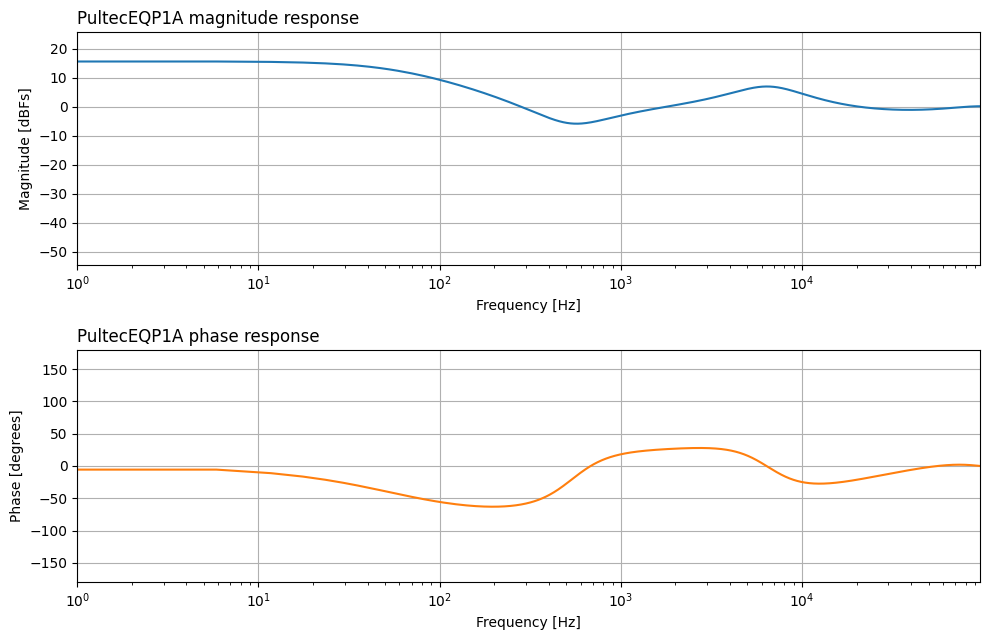

In [6]:
eqp1a = PultecEQP1A(
    fs = 192_000, LoBoost = 0.9999, LoCut = 0.6,
    HiBoost = 0.75, HiCut = 0.2, HiBQ = 0.5,
    LoFreq = 60, HiBoostFreq = 7e3, HiCutFreq = 10e3
)
eqp1a.plot_freqz()

We can also test the model with some test signals. In this case I'm feeding the EQP1A a white noise.

In [7]:
import time

def measure_performance(self, n):
    # Performance measurement
    times = []
    self.reset()
    inSamples = np.random.rand(self.fs)

    for i in trange(n):
      startTime = time.monotonic()
      for sample in inSamples:
        self.process_sample(sample)
      endTime = time.monotonic()
      times.append(endTime - startTime)

    return sum(times) / len(times)

In [10]:
eqp1a = PultecEQP1A(
    fs = 96_000, LoBoost = 0.00001, LoCut = 0.00001,
    HiBoost = 0.00001, HiCut = 0.00001, HiBQ = 0.5,
    LoFreq = 100, HiBoostFreq = 8e3, HiCutFreq = 10e3
)
time_to_process_1s_of_audio = measure_performance(eqp1a, 100)

print(f'\nTime to process 1 second of audio @ {eqp1a.fs / 1000:.0f} kHz: {time_to_process_1s_of_audio:.3} s')

100%|██████████| 100/100 [09:20<00:00,  5.60s/it]


Time to process 1 second of audio @ 96 kHz: 5.6 s


In [ ]:
mean = sum(times) / len(times)
print(f'{mean = :.4f} s')

mean = 8.3046 s


In [ ]:
def generate_white_noise(duration, sample_rate):
    num_samples = int(duration * sample_rate)
    noise = np.random.randn(num_samples)
    return noise

In [ ]:
x = generate_white_noise(3, eqp1a.fs)
y = eqp1a.process_signal(x)

In [ ]:
print('Input signal:\n')
Audio(x[:], rate = eqp1a.fs)

Input signal:



In [ ]:
print('Output signal:\n')
Audio(y[:], rate = eqp1a.fs)

Output signal:

